- title: Pseudo online LSTM RNN - part 2
- author: Amol Kelkar
- date: 2018-10-03
- category: ai
- tags: keras, lstm, rnn, online learning

#### NOTE: Please see [updated blog post](./pseudo-online-lstm-rnn-revisited.html) for this project

In the [previous post](./pseudo-online-lstm-rnn.html), we built a way to convert a stream of data points $(X_t, y_t)$ into sample batches $(X_{batch}, y_{batch})$ suitable to train an RNN. In this post, let's use that code to build an `PseudoOnlineModel` Keras model class.

## Relevant code from previous post
I have modified `OnlineToBatch` to simply return the batched data instead of calling an action

In [1]:
class SlidingWindowBuffer(object):
    def __init__(self, item_count, item_shape=(1)):
        self.item_shape = item_shape
        self.item_count = item_count
        self.buffer = []
        
    def append_item(self, item):
        # return None while gathering initial items
        if len(self.buffer) < self.item_count - 1:
            self.buffer.append(item)
            return None
        
        # once enough items, convert to np.array
        elif len(self.buffer) == self.item_count - 1:
            self.buffer.append(item)
            self.buffer = np.array(self.buffer)
            
        else:
            self.buffer = np.roll(self.buffer, -1, axis=0)
            self.buffer[-1] = item
            
        return self.buffer

class OnlineToBatch(object):
    def __init__(self, t_sample, n_batch, X_t_shape=(1,), y_t_shape=(1,)):
        self.t_sample = t_sample
        self.n_batch = n_batch
        self.X_t_shape = X_t_shape
        self.y_t_shape = y_t_shape

        self.X_points_buffer = SlidingWindowBuffer(item_count = t_sample, item_shape=X_t_shape)
        self.y_points_buffer = SlidingWindowBuffer(item_count = t_sample, item_shape=y_t_shape)

        self.reset_batch_buffer()
    
    def reset_batch_buffer(self):
        self.X_batch = []
        self.y_batch = []
        
    # add point to current batch
    def add(self, X_point, y_point, epochs=1, verbose=2):
        X_sample = self.X_points_buffer.append_item(X_point)
        y_sample = self.y_points_buffer.append_item(y_point)

        if X_sample is not None:
            assert y_sample is not None
            self.X_batch.append(X_sample)
            self.y_batch.append(y_sample)

            if len(self.X_batch) == self.n_batch:
                assert len(self.y_batch) == self.n_batch
                
                X = np.array(self.X_batch)
                assert X.shape == ((self.n_batch, self.t_sample) + self.X_t_shape)
                
                y = np.array(self.y_batch)
                assert y.shape == ((self.n_batch, self.t_sample) + self.y_t_shape)

                self.reset_batch_buffer()
                return X, y
        return None, None

## PseudoOnlineModel class

In [2]:
import keras
from keras import models

class PseudoOnlineModel(models.Model):
    def __init__(self, n_batch, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.n_batch = n_batch
        assert type(self.n_batch) == int
        
        assert len(self.inputs) == 1, "For now, only support models with a single input layer."
        input_shape = keras.backend.int_shape(self.inputs[0])
        assert input_shape[0] is None or self.n_batch == input_shape[0], "Input batch size must match if specified"
        self.t_sample = input_shape[1]
        assert type(self.t_sample) == int, "Sample length must be specified"
        self.X_t_shape = input_shape[2:]
        
        assert len(self.outputs) == 1, "For now, only support models with a single output layer."
        output_shape = keras.backend.int_shape(self.outputs[0])
        assert output_shape[0] is None or self.n_batch == output_shape[0], "Output batch size must match if specified"
        assert self.t_sample == output_shape[1], "input and output layer should use the same sample size"
        y_t_shape = output_shape[2:]
        
        self.online_to_batch = OnlineToBatch(t_sample = self.t_sample, n_batch = self.n_batch)
        
    def fit(self, training_X_point, training_y_point, *args, **kwargs):
        (X, y) = self.online_to_batch.add(training_X_point, training_y_point)
        if X is not None:
            assert y is not None
            print('calling fit() with X {0} and y {1}'.format(X.shape, y.shape))
            results = super().fit(X, y, batch_size=self.n_batch, *args, **kwargs)
            return (results, X, y)
        else:
            return (None, None, None)


Using TensorFlow backend.


## Test the new model type

In [3]:
from keras import layers

def define_model(t_sample,
                 hidden_neuron_count = 10,
                 X_t_shape=(1,),
                 n_batch=None):
    in_out_neurons = 1

    input_layer = layers.Input(batch_shape=(None, t_sample) + X_t_shape, name="input")

    rnn = layers.LSTM(hidden_neuron_count,
                    return_sequences=True,
                    name="RNN")(input_layer)

    dens = layers.TimeDistributed(layers.Dense(in_out_neurons, name="dense"))(rnn)
    model = PseudoOnlineModel(inputs=[input_layer], outputs=[dens], n_batch=n_batch)

    model.compile(loss="mean_squared_error",
                  sample_weight_mode="temporal",
                  optimizer="rmsprop")
    return(model,(input_layer,rnn,dens))

hidden_neuron_count = 64
X_t_shape = (1,)
y_t_shape = (1,)
t_sample = 900
n_batch = 500
model, _ = define_model(t_sample = t_sample, hidden_neuron_count = hidden_neuron_count, X_t_shape = X_t_shape, n_batch = n_batch)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 900, 1)            0         
_________________________________________________________________
RNN (LSTM)                   (None, 900, 64)           16896     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 900, 1)            65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


## Generate sample time series data

In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras
import sys, time
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__))
print("tensorflow version {}".format(tf.__version__))
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "0"
set_session(tf.Session(config=config))

def set_seed(sd=123):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    ## numpy random seed
    seed(sd)
    ## core python's random number
    rn.seed(sd)
    ## tensor flow's random number
    set_random_seed(sd)
    
set_seed(121)

def random_sample(len_ts=3000,D=10):
    c_range = range(5,100)
    c1 = np.random.choice(c_range)
    u = np.random.random(1)
    const = -1.0/len_ts
    ts = np.arange(0,len_ts)
    
    x1 = np.cos(ts/float(1.0 + c1))
    x1 = x1*ts*u*const
    
    y1 = np.zeros(len_ts)

    for t in range(D,len_ts):
        ## the output time series depend on input as follows: 
        y1[t] = x1[t-2]*x1[t-D] 
    y = np.array([y1]).T
    X = np.array([x1]).T
    return X, y

def plot_sample(sample):
    if len(sample) == 2:
        (X, y) = sample
        y2 = None
    elif len(sample) == 3:
        (X, y, y2) = sample
    else:
        assert(False, 'Sample must be (X, y) or (X, y, y2)')

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(1,1,1)
    ax.set_ylim(-0.5,0.5)
    ax.plot(X[:,0],"--",label="X")
    ax.plot(y[:,0],label="y",linewidth=3,alpha = 0.5)
    if y2 is not None:
        ax.plot(y2[:,0],label="y_pred",linewidth=2,alpha = 0.5)

    ax.set_title("Sample time series data")
    plt.legend()
    plt.show()

python 3.6.5 | packaged by conda-forge | (default, Apr  6 2018, 13:44:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]
keras version 2.2.2
tensorflow version 1.10.0


In [5]:
class SampleDataPointsGenerator(object):
    def __init__(self, ts=3000):
        self.sample_data = None
        self.ts = ts
        self.index = 0
        
    def __next__(self):
        if self.sample_data == None or self.index == self.ts:
            self.sample_data = random_sample(len_ts = self.ts)
            self.index = 0
            
        retval = (self.sample_data[0][self.index], self.sample_data[1][self.index])
        self.index += 1
        return retval

## Train model online by feeding a stream of points

Points are generated for multiple samples and fed into the model as a stream. Charts below show discontinuities where samples are joined.

calling fit() with X (500, 900, 1) and y (500, 900, 1)


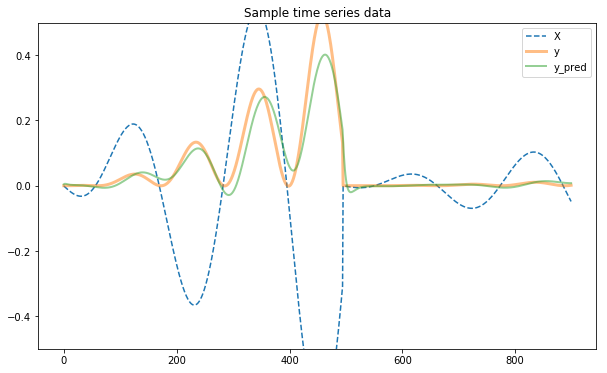

calling fit() with X (500, 900, 1) and y (500, 900, 1)


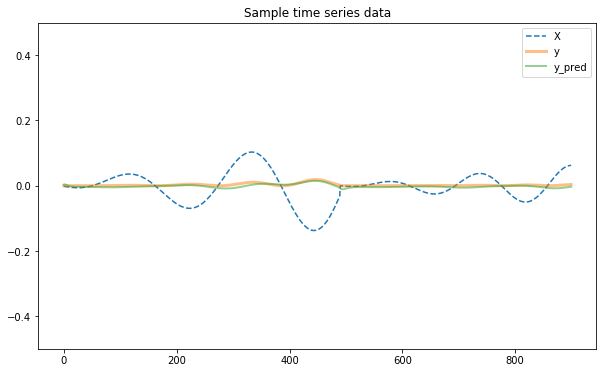

calling fit() with X (500, 900, 1) and y (500, 900, 1)


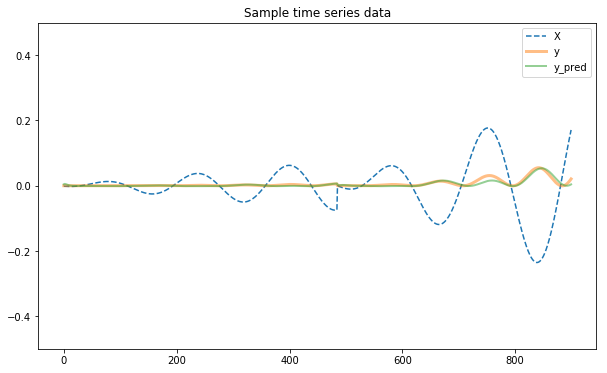

calling fit() with X (500, 900, 1) and y (500, 900, 1)


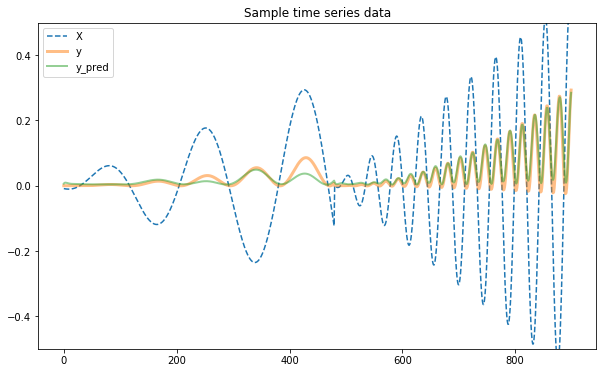

Time Took :2.54 min


In [6]:
ts = int(t_sample * 1.1)

training_points_generator = SampleDataPointsGenerator(ts)

start = time.time()

for i_point in range(3200):
    (training_X_point, training_y_point) = next(training_points_generator)
    (history, X_batch, y_batch) = model.fit(*next(training_points_generator), epochs=20, verbose=False)

    if history:
        # take first sample in the batch and get predicted y
        preds = model.predict([[X_batch[0]]])[0]

        plot_sample((X_batch[0], y_batch[0], preds))
    
end = time.time()
print("Time Took :{:3.2f} min".format( (end-start)/60 ))


## Test the model

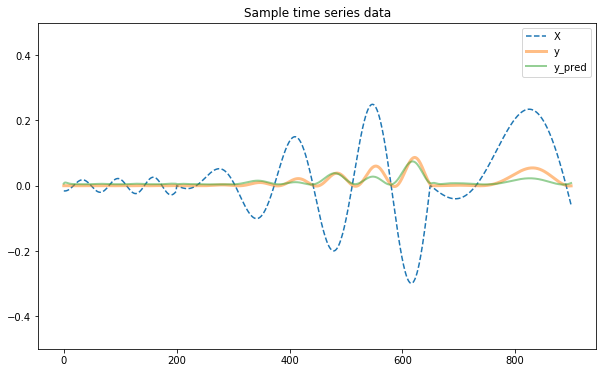

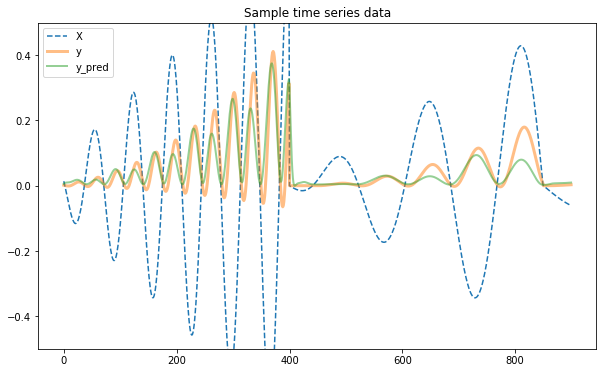

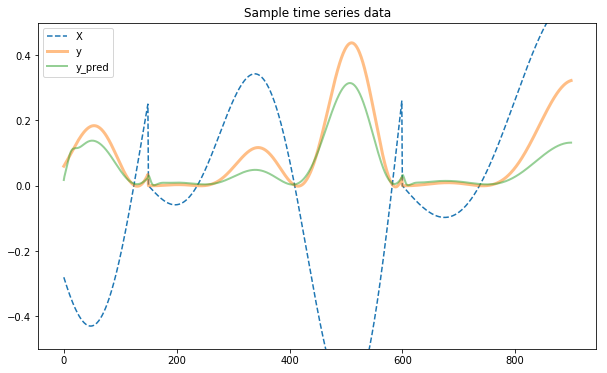

In [8]:
test_points_generator = SampleDataPointsGenerator(int(t_sample * 0.5))

for i in range(3):
    test_sample_X = []
    test_sample_y = []

    # skip some data
    for _ in range(2500):
        next(test_points_generator)

    for _ in range(t_sample):
        (X, y) = next(test_points_generator)
        test_sample_X.append(X)
        test_sample_y.append(y)

    preds = model.predict([[test_sample_X]])

    if preds is not None:
        plot_sample((np.array(test_sample_X), np.array(test_sample_y), preds[0]))




## Next steps

Now that we have `PseudoOnlineModel` model available, we will use it to build an online predictive coding network.